In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2.2.2


In [2]:
hydrodf = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/hphob_dict_lig47")

In [3]:
frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

(1100889, 1500)


In [ ]:
print(hydrocombined.shape)

(1100889, 1500)


In [6]:
print(len(hydrodf.keys()))
print(hydrodf.keys())
df1 = hydrodf['TYR133']
print(df1.keys())

20
dict_keys(['ASP121', 'ASN122', 'GLU123', 'ALA124', 'TYR125', 'GLU126', 'MET127', 'PRO128', 'SER129', 'GLU130', 'GLU131', 'GLY132', 'TYR133', 'GLN134', 'ASP135', 'TYR136', 'GLU137', 'PRO138', 'GLU139', 'ALA140'])
dict_keys(['hphob_pairs', 'distance', 'prot_atom', 'distances'])


In [12]:
print(len(df1['hphob_pairs']))
print(len(df1['distance']))
print(len(df1['prot_atom']))
print(len(df1['distances']))

135
1100889
135
1100889


In [9]:
df = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_hbonds_dict")

In [3]:
print(len(df.keys()))
print(df.keys())

for key in df.keys():
  print(key)
  print(df[key]['atoms'])
  
df1 = df['TYR133']

print(df1.keys())
print(df1['atoms'])
print(df1['distances'])
print(df1['distances'].shape)

# (donor atom number) (hydrogen atom number) (acceptor atom number (on ligand for all except))

# h bond cutoff of 0.35 nm Baker Hubbard

# still predict overall residence time

# ---------------------------------
# hydrophobic
# ()

21
dict_keys(['ASP121', 'ASN122', 'GLU123', 'ALA124', 'TYR125', 'GLU126', 'MET127', 'PRO128', 'SER129', 'GLU130', 'GLU131', 'GLY132', 'TYR133', 'GLN134', 'ASP135', 'TYR136', 'GLU137', 'PRO138', 'GLU139', 'ALA140', '<1>1'])
ASP121
[[  0   8 299]
 [  0   8 300]
 [  0   8 316]
 [  0   8 317]
 [  0   8 318]
 [  0   8 319]
 [  0   8 329]]
ASN122
[[ 12  20 329]
 [ 12  20 319]
 [ 12  20 318]
 [ 12  20 316]
 [ 12  20 300]
 [ 12  20 299]
 [ 12  20 317]
 [ 19  25 300]
 [ 19  25 319]
 [ 19  25 318]
 [ 19  25 317]
 [ 19  25 316]
 [ 19  25 299]
 [ 19  25 329]
 [ 19  24 319]
 [ 19  24 299]
 [ 19  24 300]
 [ 19  24 329]
 [ 19  24 317]
 [ 19  24 318]
 [ 19  24 316]]
GLU123
[[ 26  35 299]
 [ 26  35 316]
 [ 26  35 317]
 [ 26  35 318]
 [ 26  35 319]
 [ 26  35 329]
 [ 26  35 300]]
ALA124
[[ 41  46 329]
 [ 41  46 318]
 [ 41  46 319]
 [ 41  46 316]
 [ 41  46 300]
 [ 41  46 299]
 [ 41  46 317]]
TYR125
[[ 51  63 299]
 [ 51  63 300]
 [ 51  63 316]
 [ 51  63 317]
 [ 51  63 318]
 [ 51  63 319]
 [ 51  63 329]
 [ 

In [10]:
frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

(1100889, 314)


In [4]:
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/aro_contacts.npy")

(1100889, 3)
[0. 0. 0. ... 0. 0. 0.]


(array([946393.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
        154496.]),
 array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181818,
        0.22727273, 0.27272727, 0.31818182, 0.36363636, 0.40909091,
        0.45454545, 0.5       , 0.54545455, 0.59090909, 0.63636364,
        0.68181818, 0.72727273, 0.77272727, 0.81818182, 0.86363636,
        0.90909091, 0.95454545, 1.        ]),
 <BarContainer object of 22 artists>)

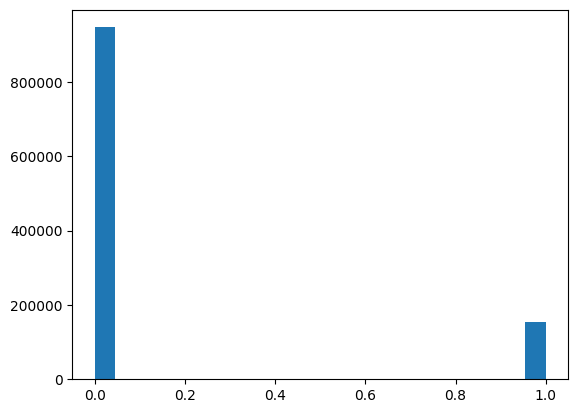

In [9]:
print(dfaro.shape)

print(dfaro[:,0])

plt.hist(dfaro[:,0], bins='auto')


In [5]:
dcharges = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/charge_dist_matrix.npy")
print(dcharges.shape)

(1100889, 9)


(array([1.2000e+01, 2.8000e+01, 5.7000e+01, 1.0300e+02, 1.3600e+02,
        1.4000e+02, 1.5800e+02, 1.9200e+02, 1.9200e+02, 2.6100e+02,
        2.7800e+02, 3.1300e+02, 3.4500e+02, 4.3800e+02, 4.9400e+02,
        4.2200e+02, 4.9500e+02, 4.7700e+02, 5.6300e+02, 6.1500e+02,
        7.1800e+02, 7.1900e+02, 8.7300e+02, 9.7800e+02, 1.0380e+03,
        1.1180e+03, 1.1830e+03, 1.3340e+03, 1.4120e+03, 1.5190e+03,
        1.6790e+03, 1.7960e+03, 1.8350e+03, 1.9130e+03, 2.0830e+03,
        2.1540e+03, 2.1490e+03, 2.3180e+03, 2.3590e+03, 2.5010e+03,
        2.6550e+03, 2.6820e+03, 2.9540e+03, 2.9930e+03, 3.3130e+03,
        3.4240e+03, 3.6370e+03, 3.8020e+03, 4.0030e+03, 4.2170e+03,
        4.3470e+03, 4.6900e+03, 4.8620e+03, 5.1340e+03, 5.3620e+03,
        5.8460e+03, 5.9650e+03, 6.2100e+03, 6.4550e+03, 6.6310e+03,
        6.9710e+03, 6.8740e+03, 7.1740e+03, 7.2040e+03, 7.3400e+03,
        7.3870e+03, 7.4910e+03, 7.3540e+03, 7.4390e+03, 7.6320e+03,
        7.7080e+03, 7.8120e+03, 7.9030e+03, 8.00

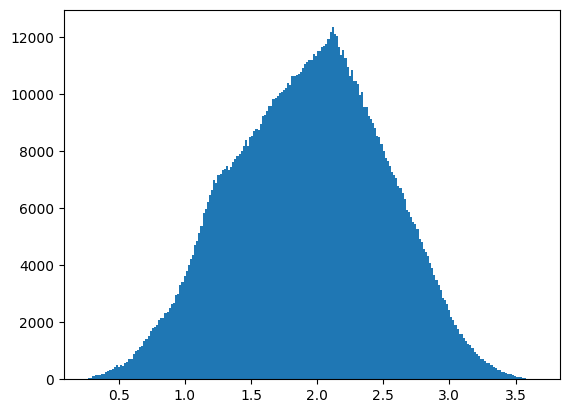

In [11]:
plt.hist(dcharges[:,0], bins='auto')

In [6]:
dmat = np.load("distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

(1100889, 20)


In [46]:
# inputs = torch.from_numpy(std_avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)
# print(inputs.shape)
# print(inputs)
# targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)
# print(targets.shape)
# print(targets)
# dataset = TensorDataset(inputs, targets)

# N = dmat.shape[0]
N = 4589
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

3212
[   0    1    2 ... 3209 3210 3211]
459
[3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225
 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239
 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253
 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267
 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281
 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295
 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309
 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323
 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337
 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351
 3352 3353 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365
 3366 3367 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379
 3380 3381 3382 3383 3384 3385 3386 3387 3388 3389 3390 3391 3392 3393
 3394 3395 3396 3397 3398 3399 3

In [12]:
# events_all = combined_residence_events(dmat)
# mapping_all = np.zeros(len(events_all))
# avg_all = np.zeros([len(events_all), len(dmat[0,:])])
# mapping_5_476 = np.zeros(len(events_all))
# avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
# mapping_25_476 = np.zeros(len(events_all))
# avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


# avg_hbond_all = np.zeros([len(events_all), len(combined[0,:])])
# avg_aro_all = np.zeros([len(events_all), len(dfaro[0,:])])
# avg_charges_all = np.zeros([len(events_all), len(dcharges[0,:])])

# # avg_all is all events
# # avg_5_476 is middle range
# # avg_25_476 is narrowest range
# rng = np.random.default_rng()
# count = 0
# for event in events_all:
#   if len(event) < 5:
#     choice = [0,0,0,0,0]
#   else:
#     choice = rng.choice(event, size=5, replace=False)
#   mapping_all[count] = len(event)
#   middle = int((event[0] + event[-1])/2)
#   avg_all[count] = np.mean(dmat[middle:middle+5], axis=0)
#   avg_hbond_all[count] = np.mean(combined[middle:middle+5], axis=0)
#   avg_aro_all[count] = np.mean(dfaro[middle:middle+5], axis=0)
#   avg_charges_all[count] = np.mean(dcharges[middle:middle+5], axis=0)
#   count += 1
  
# avg_new = np.concatenate([avg_all,avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)
# # avg_new = np.concatenate([avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)

# # stats
# sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
# print("Longest five events:", sortevents[:5])


# # Getting different ranges
# mapping_5_476 = mapping_all[mapping_all > 4]
# avg_5_476 = avg_new[mapping_all > 4]
# avg_5_476 = avg_5_476[mapping_5_476 < 477]
# mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

# mapping_25_476 = mapping_all[mapping_all > 24]
# avg_25_476 = avg_new[mapping_all > 24]
# avg_25_476 = avg_25_476[mapping_25_476 < 477]
# mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

# print("Total events:", len(mapping_all))
# print("With avg distance input data of shape:", avg_new.shape)

# print("Events between 5 and 476 frames:", len(mapping_5_476))
# print("With avg distance in put data of shape:", avg_5_476.shape)

# print("Events between 25 and 476 frames:", len(mapping_25_476))
# print("With avg distance input data of shape:", avg_25_476.shape)

In [47]:
# events_all = combined_residence_events(dmat)
# mapping_all = np.zeros(len(events_all))
# avg_all = np.zeros([len(events_all), 5, len(dmat[0,:])])
# mapping_5_476 = np.zeros(len(events_all))
# avg_5_476 = np.zeros([len(events_all), 5, len(dmat[0,:])])
# mapping_25_476 = np.zeros(len(events_all))
# avg_25_476 = np.zeros([len(events_all), 5, len(dmat[0,:])])


# avg_hbond_all = np.zeros([len(events_all), 5, len(combined[0,:])])
# avg_aro_all = np.zeros([len(events_all), 5, len(dfaro[0,:])])
# avg_charges_all = np.zeros([len(events_all), 5, len(dcharges[0,:])])
# avg_hydro_all = np.zeros([len(events_all), 5, len(hydrocombined[0,:])])

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(combined[0,:])])
avg_aro_all = np.zeros([len(events_all), len(dfaro[0,:])])
avg_charges_all = np.zeros([len(events_all), len(dcharges[0,:])])
avg_hydro_all = np.zeros([len(events_all), len(hydrocombined[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range
rng = np.random.default_rng()
count = 0
for event in events_all:
  if len(event) < 5:
    choice = [0,0,0,0,0]
  else:
    choice = rng.choice(event, size=5, replace=False)
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(combined[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(dfaro[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(dcharges[event[0]:event[-1]+1], axis=0)
  avg_hydro_all[count] = np.mean(hydrocombined[event[0]:event[-1]+1], axis=0)
  count += 1
  
avg_new = np.concatenate([avg_all,avg_hydro_all,avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)
# avg_new = np.concatenate([avg_all,avg_hydro_all,avg_hbond_all, avg_aro_all, avg_charges_all], axis=2)
# avg_new = np.concatenate([avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])


# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)


Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 1846)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 1846)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 1846)


In [48]:
mapping = mapping_25_476
avg = avg_25_476


In [49]:
print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

max length: 476.0
min length: 25.0
max log length: 4.76
min log length: 0.25
mean: [1.40415347 1.31558024 1.25312192 ... 1.69520545 1.78029688 1.84068152]
std deviation: [0.40974069 0.45059288 0.485467   ... 0.41810974 0.42228237 0.4052563 ]
standardized avg distance data


In [50]:
a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]
print(a1.shape)

(3212, 1846)


In [51]:
a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)
print(a1.shape)

(3212, 1846)


In [49]:
# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
# clf = TabNetRegressor()
# clf.fit(
#   a1, m1.reshape(-1, 1),
#   eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=80
# )

In [52]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=80
)

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.71206 | val_0_mse: 2.03539 |  0:00:01s
epoch 1  | loss: 2.60191 | val_0_mse: 1.77309 |  0:00:03s
epoch 2  | loss: 1.73295 | val_0_mse: 1.53754 |  0:00:05s
epoch 3  | loss: 1.38623 | val_0_mse: 1.26603 |  0:00:06s
epoch 4  | loss: 1.23367 | val_0_mse: 1.044   |  0:00:08s
epoch 5  | loss: 1.07033 | val_0_mse: 0.99408 |  0:00:09s
epoch 6  | loss: 0.91808 | val_0_mse: 0.91288 |  0:00:11s
epoch 7  | loss: 0.89423 | val_0_mse: 0.86632 |  0:00:12s
epoch 8  | loss: 0.87599 | val_0_mse: 0.8685  |  0:00:14s
epoch 9  | loss: 0.86316 | val_0_mse: 0.86325 |  0:00:16s
epoch 10 | loss: 0.87236 | val_0_mse: 0.84742 |  0:00:18s
epoch 11 | loss: 0.83043 | val_0_mse: 0.86807 |  0:00:19s
epoch 12 | loss: 0.82557 | val_0_mse: 0.91353 |  0:00:21s
epoch 13 | loss: 0.80929 | val_0_mse: 0.85094 |  0:00:22s
epoch 14 | loss: 0.83247 | val_0_mse: 0.8734  |  0:00:24s
epoch 15 | loss: 0.81724 | val_0_mse: 0.83088 |  0:00:26s
epoch 16 | loss: 0.783   | val_0_mse: 0.86028 |  0:00:28s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [53]:
preds = clf.predict(a3)
preds = preds[:,0]

In [54]:
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[1.2294321  0.5609138  1.1765146  1.3284568  0.4673066  0.8376255
 1.0107172  1.6474369  0.7481023  0.8886397  1.5140086  1.6743699
 1.9935024  1.041701   0.82161856 1.3353561  1.3802791  1.4198736
 0.981935   0.36335987 0.7208649  0.3434827  0.4834876  2.1813173
 0.6712626  1.8664539  2.0435867  1.406496   0.40057638 1.1873673
 1.0572603  0.8288242  1.0432327  1.2157991  2.3040128  2.044658
 0.8480356  2.488361   0.753143   0.5018553  0.5768273  2.1205654
 0.69659925 1.0309694  1.3709509  0.27358323 0.8089733  2.0967715
 0.8176609  0.62675667 0.94846094 1.9845665  1.1560569  2.0208488
 1.3052694  1.3021724  0.49152666 1.1726031  0.69202864 1.0312575
 1.6126573  0.4831725  0.74765444 1.9271182  0.7997327  0.5177634
 1.1042993  0.5593096  2.9309819  0.96095866 1.9735066  2.002359
 0.83853054 1.0798439  1.7946818  0.9695501  1.1851714  1.1352681
 0.4852394  1.8104589  1.2482474  1.5099192  1.0092597  1.1578639
 1.1549935  0.2972831  2.3043501  1.4468763  1.4466419  1.1237925
 0.5068401  

In [55]:
top = (-al2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
top = (-ap2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
bottom = (ap2).argsort(axis=0)[:10]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted 255.5753 real: 475.0
predicted 120.44135 real: 471.0
predicted 226.64104 real: 467.0
predicted 270.45752 real: 467.0
predicted 117.65146 real: 462.0
predicted 151.49365 real: 461.00000000000006
predicted 241.32147 real: 461.00000000000006
predicted 227.45142 real: 454.0
predicted 249.41228 real: 454.0
predicted 213.26666 real: 448.00000000000006

predicted 351.60397 real: 202.0
predicted 325.5487 real: 216.0
predicted 308.22797 real: 361.0
predicted 305.8124 real: 419.00000000000006
predicted 295.303 real: 303.0
predicted 293.09818 real: 423.00000000000006
predicted 283.89996 real: 114.99999999999999
predicted 283.22922 real: 390.0
predicted 281.50262 real: 92.0
predicted 278.81323 real: 134.0

predicted 19.161358 real: 26.0
predicted 21.808815 real: 31.0
predicted 26.707632 real: 40.0
predicted 27.358324 real: 51.0
predicted 28.094881 real: 40.0
predicted 28.318542 real: 26.0
predicted 29.728312 real: 38.0
predicted 29.867107 real: 44.0
predicted 30.689049 real: 47.0
predict

r2: 0.5869394531180766


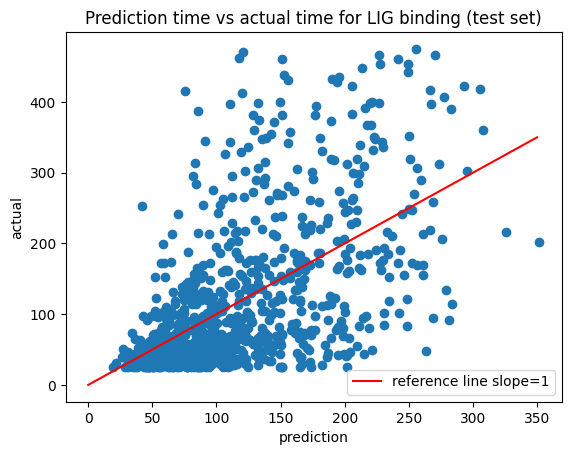

In [57]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#average, all sources, 98% range above 25

r2: 0.7305547588538986


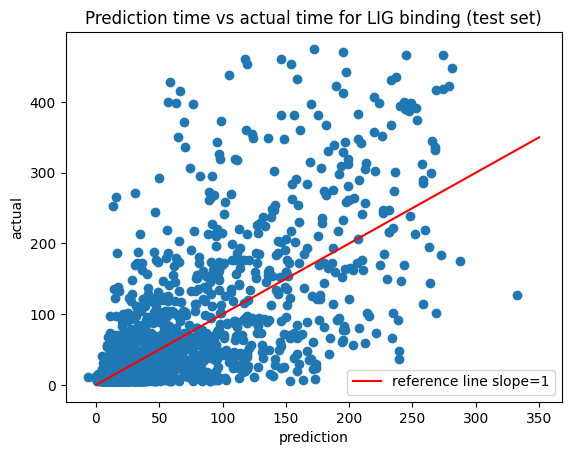

In [82]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#average 5 random frames

r2: 0.19200392962132046


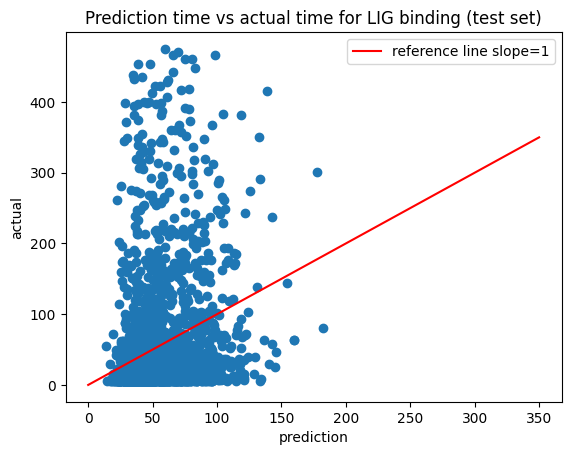

In [92]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#average first 5 frames

r2: 0.7096678952192573


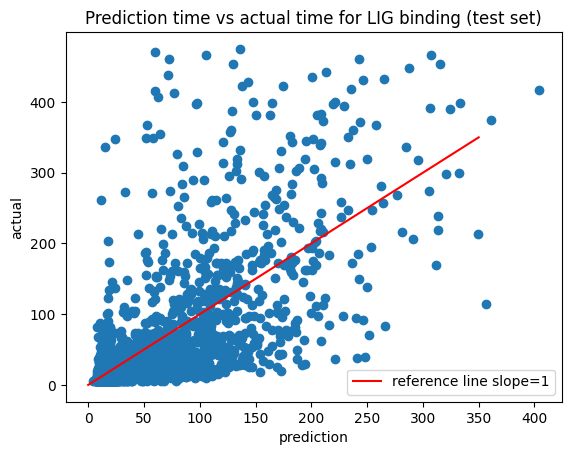

In [101]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#5 middle frames

r2: 0.6935154094609133


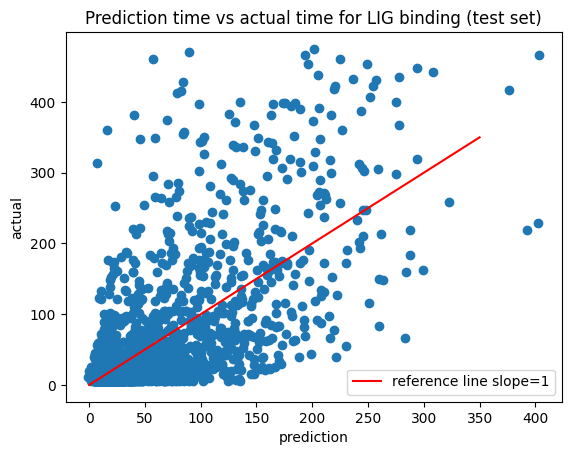

In [55]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#5 random frames

r2: 0.6472992720098634


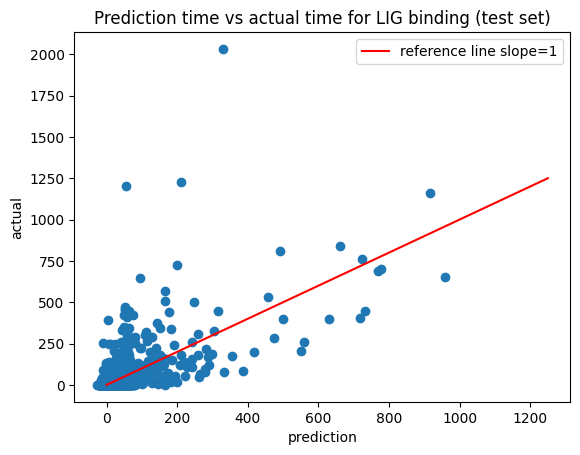

In [42]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 1250,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#whole dataset, all data included, averages

r2: 0.7844862029996782


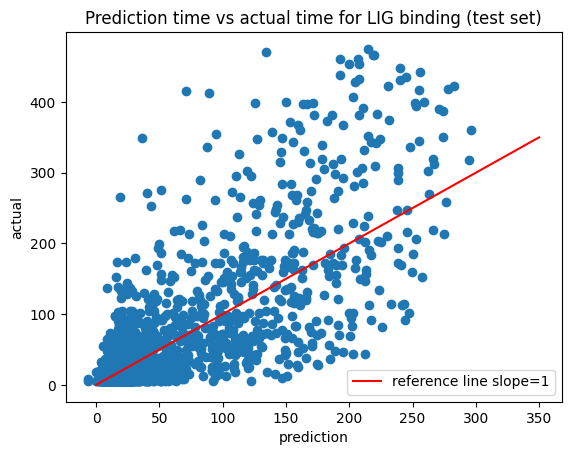

In [28]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#all data averages